# MICrONS Dataset Exploration

This notebook provides exploratory data analysis (EDA) of the MICrONS
minnie65 dataset at full resolution (mip 0, 8x8x40 nm).

## Contents
1. Load EM + segmentation (mip 0)
2. Visualize EM and segmentation slices
3. Segmentation label distribution
4. Resolution and dataset metadata

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

from neurons.preprocessors import HDF5Preprocessor
from neurons.utils.io import load_volume

hdf5 = HDF5Preprocessor()

# ---------- Matplotlib defaults: LaTeX font, tab20, aspect=equal ----------
matplotlib.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'cm',
    'font.size': 12,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
})

CMAP_LABELS = plt.cm.tab20

%matplotlib inline

## 1. Load EM + Segmentation (mip 0)

MICrONS minnie65 at full resolution (8 x 8 x 40 nm).

Files:
```
minnie65_mip0_crop_1024_volume.h5
minnie65_mip0_crop_1024_v1300_segmentation.h5
```

Set `DATA_ROOT` to the directory containing the downloaded crops.

In [2]:
DATA_ROOT = Path('/scratch/MICRONS')

vol_path = DATA_ROOT / 'minnie65_mip0_crop_1024_volume.h5'
seg_path = DATA_ROOT / 'minnie65_mip0_crop_1024_v1300_segmentation.h5'

volume = None
segmentation = None

if vol_path.exists():
    volume = load_volume(vol_path)
    print(f'EM volume:')
    print(f'  path  : {vol_path.name}')
    print(f'  shape : {volume.shape}')
    print(f'  dtype : {volume.dtype}')
    print(f'  range : [{volume.min()}, {volume.max()}]')
else:
    print(f'EM not found: {vol_path}')

print()

if seg_path.exists():
    segmentation = load_volume(seg_path)
    n_ids = len(np.unique(segmentation))
    print(f'Segmentation (v1300):')
    print(f'  path  : {seg_path.name}')
    print(f'  shape : {segmentation.shape}')
    print(f'  dtype : {segmentation.dtype}')
    print(f'  unique: {n_ids} segment IDs')
else:
    print(f'Seg not found: {seg_path}')

EM volume:
  path  : minnie65_mip0_crop_1024_volume.h5
  shape : (1024, 1024, 1024)
  dtype : uint8
  range : [27, 225]

Segmentation (v1300):
  path  : minnie65_mip0_crop_1024_v1300_segmentation.h5
  shape : (1024, 1024, 1024)
  dtype : uint64
  unique: 10064 segment IDs


## 2. Visualize EM and Segmentation Slices

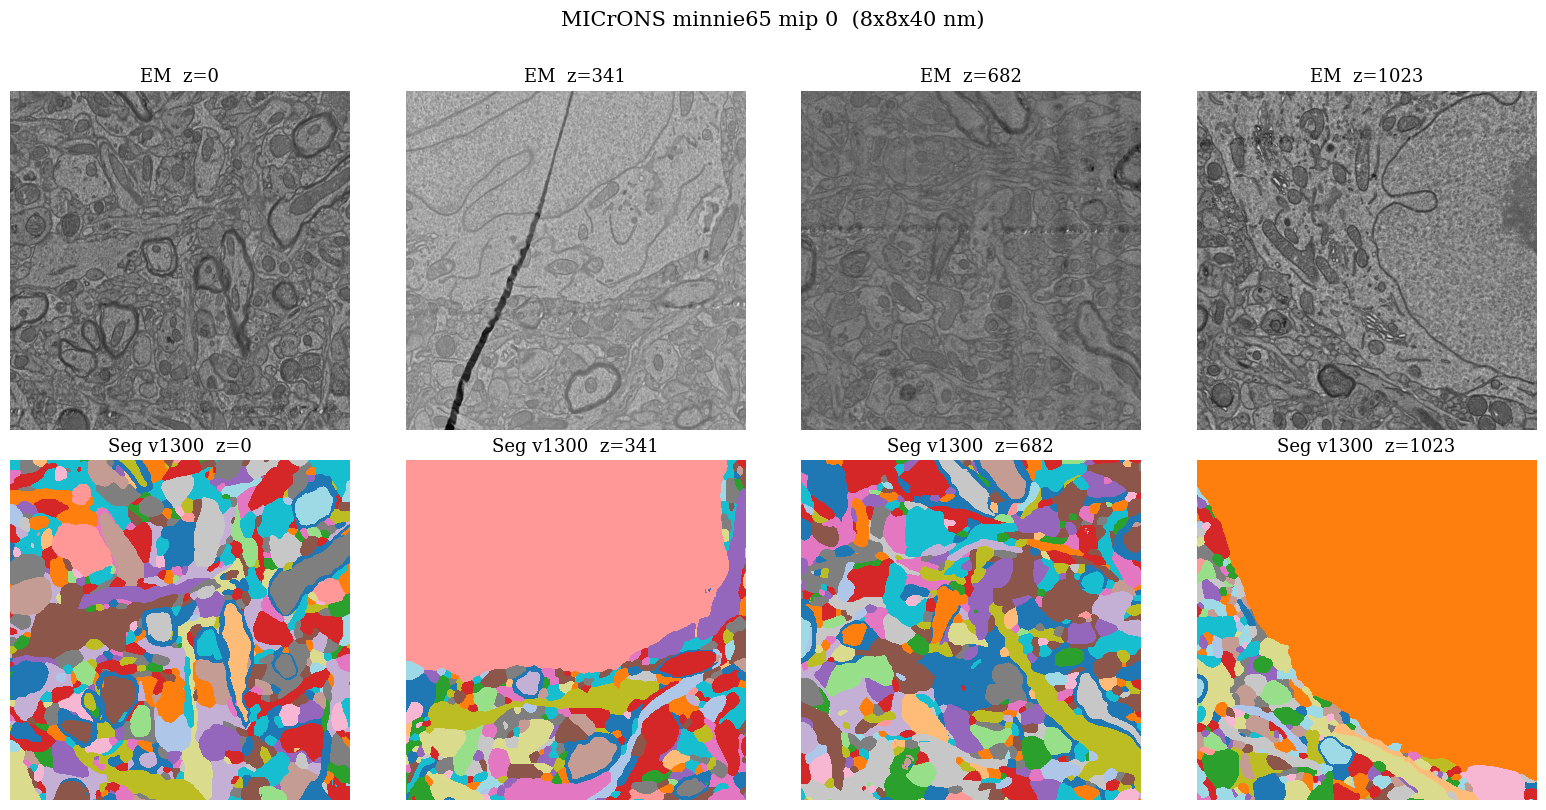

In [3]:
if volume is not None:
    has_seg = segmentation is not None
    n_rows = 2 if has_seg else 1

    slice_indices = np.linspace(0, volume.shape[0] - 1, 4, dtype=int)

    fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4 * n_rows))
    if n_rows == 1:
        axes = axes[np.newaxis, :]

    for i, idx in enumerate(slice_indices):
        axes[0, i].imshow(volume[idx], cmap='gray', aspect='equal')
        axes[0, i].set_title(f'EM  z={idx}')
        axes[0, i].axis('off')

        if has_seg:
            axes[1, i].imshow(segmentation[idx] % 20, cmap=CMAP_LABELS,
                              interpolation='nearest', aspect='equal')
            axes[1, i].set_title(f'Seg v1300  z={idx}')
            axes[1, i].axis('off')

    fig.suptitle('MICrONS minnie65 mip 0  (8x8x40 nm)', fontsize=15, y=1.01)
    fig.tight_layout()
    plt.show()
else:
    print('No EM data to visualize.')

## 3. Segmentation Label Distribution

Background voxels :     38,319,033 (3.6%)
Foreground voxels :  1,035,422,791 (96.4%)
Neuron instances  : 10063
Total voxels      :  1,073,741,824


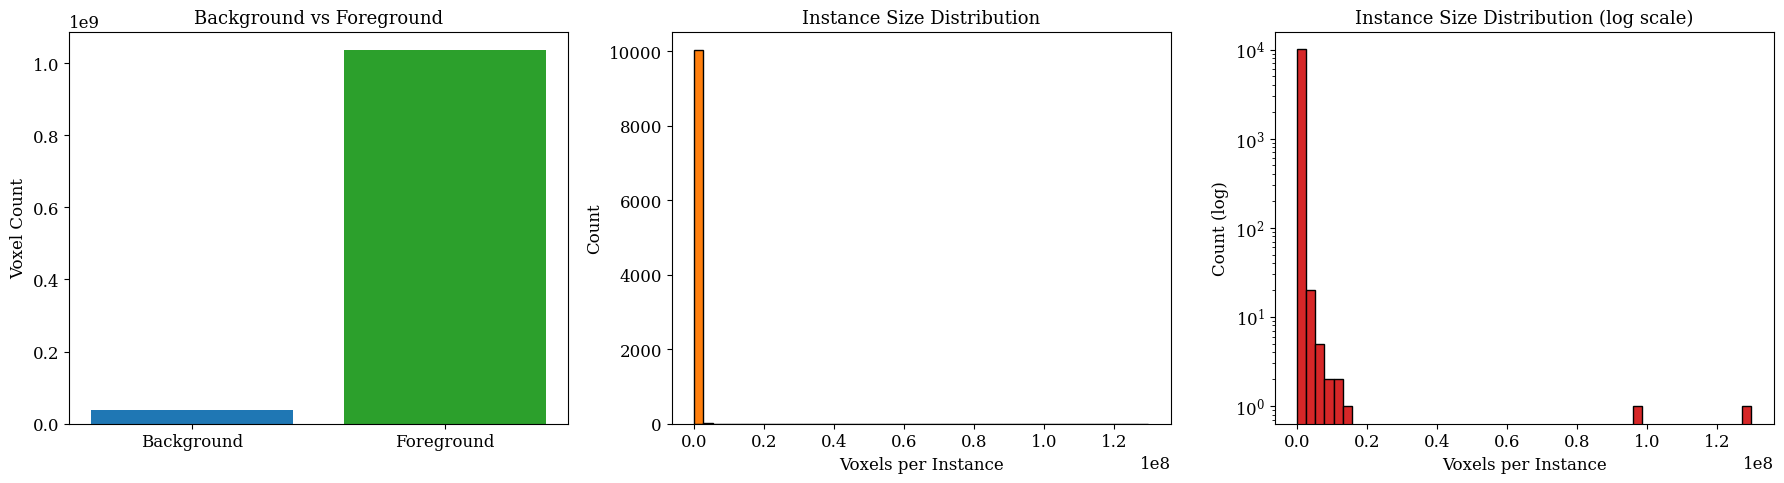


Top 10 largest instances:
  #1  ID=864691136617970907  voxels=129,691,092
  #2  ID=864691135697050522  voxels=97,260,699
  #3  ID=864691135860068200  voxels=13,565,830
  #4  ID=864691135564648535  voxels=12,896,316
  #5  ID=864691136486926098  voxels=11,378,286
  #6  ID=864691135195780906  voxels= 9,680,836
  #7  ID=864691135117784029  voxels= 9,364,536
  #8  ID=864691135473357414  voxels= 7,411,677
  #9  ID=864691136579017378  voxels= 6,995,578
  #10  ID=864691135473388390  voxels= 6,791,493


In [4]:
if segmentation is not None:
    unique_ids, counts = np.unique(segmentation, return_counts=True)

    bg_count = int(counts[unique_ids == 0].sum()) if 0 in unique_ids else 0
    fg_count = int(counts[unique_ids > 0].sum())
    n_instances = len(unique_ids[unique_ids > 0])
    fg_counts = counts[unique_ids > 0]

    print(f'Background voxels : {bg_count:>14,} ({100 * bg_count / segmentation.size:.1f}%)')
    print(f'Foreground voxels : {fg_count:>14,} ({100 * fg_count / segmentation.size:.1f}%)')
    print(f'Neuron instances  : {n_instances}')
    print(f'Total voxels      : {segmentation.size:>14,}')

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].bar(['Background', 'Foreground'], [bg_count, fg_count],
                color=[CMAP_LABELS(0), CMAP_LABELS(4)])
    axes[0].set_title('Background vs Foreground')
    axes[0].set_ylabel('Voxel Count')
    axes[0].set_aspect('auto')

    axes[1].hist(fg_counts, bins=50, edgecolor='black', color=CMAP_LABELS(2))
    axes[1].set_title('Instance Size Distribution')
    axes[1].set_xlabel('Voxels per Instance')
    axes[1].set_ylabel('Count')
    axes[1].set_aspect('auto')

    axes[2].hist(fg_counts, bins=50, edgecolor='black', color=CMAP_LABELS(6), log=True)
    axes[2].set_title('Instance Size Distribution (log scale)')
    axes[2].set_xlabel('Voxels per Instance')
    axes[2].set_ylabel('Count (log)')
    axes[2].set_aspect('auto')

    fig.tight_layout()
    plt.show()

    # Top-10 largest instances
    print(f'\nTop 10 largest instances:')
    top_idx = np.argsort(fg_counts)[::-1][:10]
    for rank, i in enumerate(top_idx):
        print(f'  #{rank+1}  ID={unique_ids[unique_ids > 0][i]:>12}  voxels={fg_counts[i]:>10,}')
else:
    print('No segmentation data to analyze.')

## 4. Resolution and Dataset Metadata

In [5]:
resolution = {'x': 8.0, 'y': 8.0, 'z': 40.0}  # nanometers (mip 0)
anisotropy = resolution['z'] / resolution['x']

print(f'Resolution (mip 0)  : {resolution}')
print(f'Anisotropy (Z/XY)   : {anisotropy:.1f}x')
print()
print(f'Full volume (mip 0) : 212,992 x 180,224 x 13,088 voxels')
print(f'This crop           : 1,024 x 1,024 x 1,024 voxels')
print(f'Crop origin         : (140000, 100000, 20000)')
print()
print(f'Seg version         : v1300 (static, proofread January 2025)')
print(f'Source              : AWS / Google Cloud public buckets')

Resolution (mip 0)  : {'x': 8.0, 'y': 8.0, 'z': 40.0}
Anisotropy (Z/XY)   : 5.0x

Full volume (mip 0) : 212,992 x 180,224 x 13,088 voxels
This crop           : 1,024 x 1,024 x 1,024 voxels
Crop origin         : (140000, 100000, 20000)

Seg version         : v1300 (static, proofread January 2025)
Source              : AWS / Google Cloud public buckets
